In [19]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
data=pd.read_csv("/content/insurance.csv")
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [45]:
data.tail()

,age,sex,bmi,children,smoker,region,charges
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
data.isnull().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


In [6]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


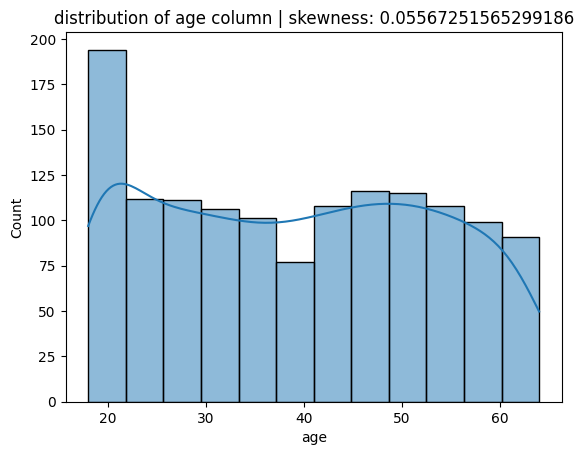

In [7]:
sns.histplot(data.age, kde=True)
plt.title(f"distribution of age column | skewness: {data.age.skew()}")
plt.show()

In [8]:
data.select_dtypes(include=np.number).columns

Index(['age', 'bmi', 'children', 'charges'], dtype='object')

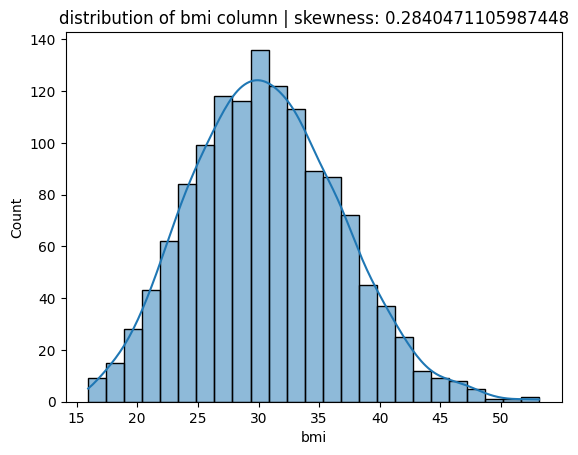

In [9]:
sns.histplot(data.bmi, kde=True)
plt.title(f"distribution of bmi column | skewness: {data.bmi.skew()}")
plt.show()

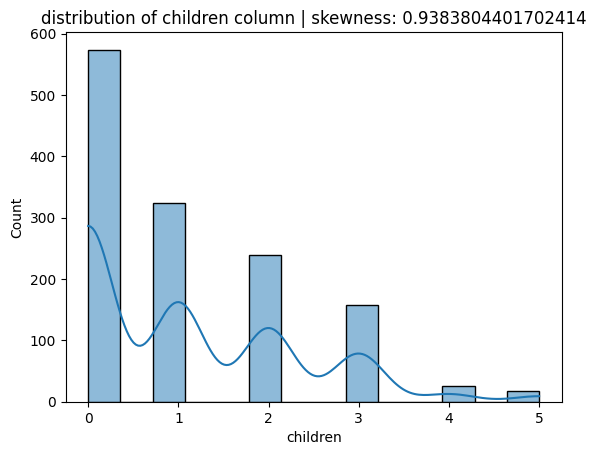

In [10]:
sns.histplot(data.children, kde=True)
plt.title(f"distribution of children column | skewness: {data.children.skew()}")
plt.show()

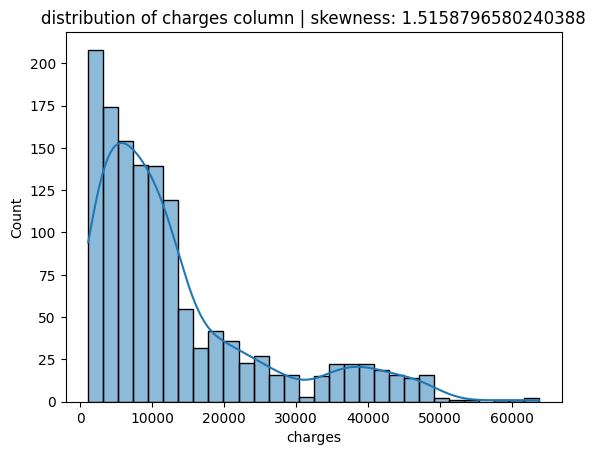

In [11]:
sns.histplot(data.charges, kde=True)
plt.title(f"distribution of charges column | skewness: {data.charges.skew()}")
plt.show()

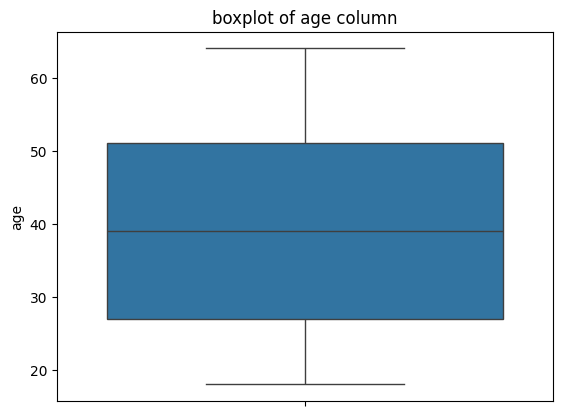

----------------------------------------------------------------------------------------------------


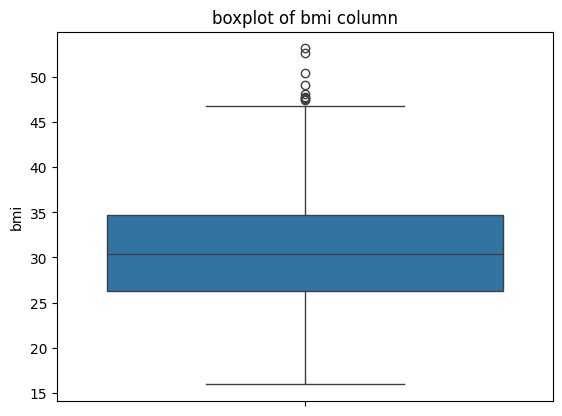

----------------------------------------------------------------------------------------------------


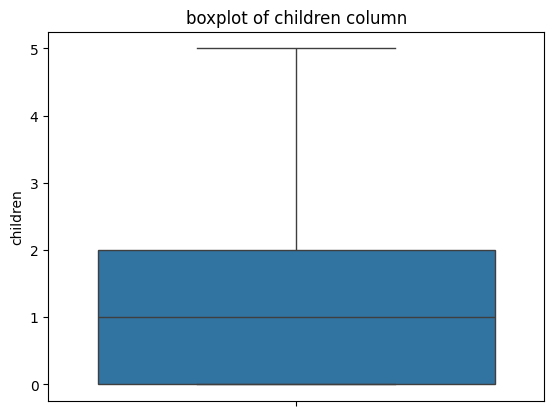

----------------------------------------------------------------------------------------------------


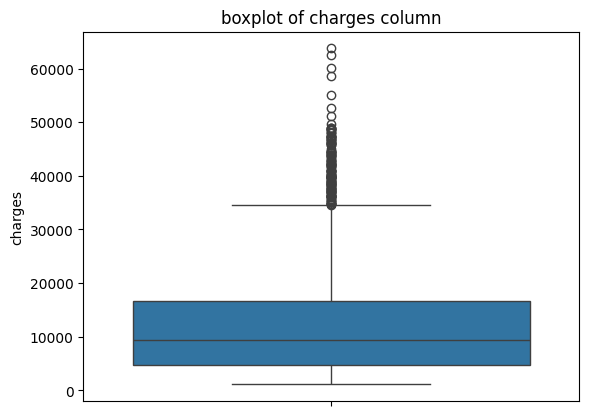

----------------------------------------------------------------------------------------------------


In [14]:
for i in data.select_dtypes(include=np.number).columns.tolist():
    sns.boxplot(data[i])
    plt.title(f"boxplot of {i} column")
    plt.show()
    print("-"*100)

In [15]:
data.select_dtypes(include=np.number).columns.tolist()

['age', 'bmi', 'children', 'charges']

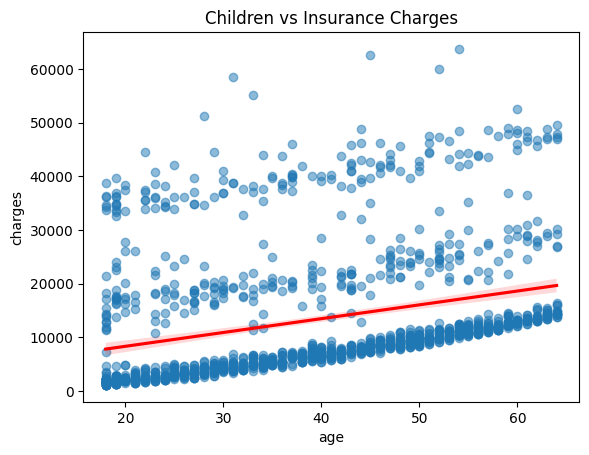

----------------------------------------------------------------------------------------------------


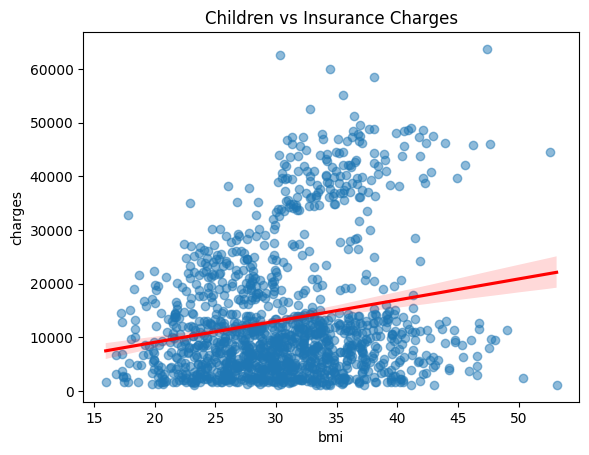

----------------------------------------------------------------------------------------------------


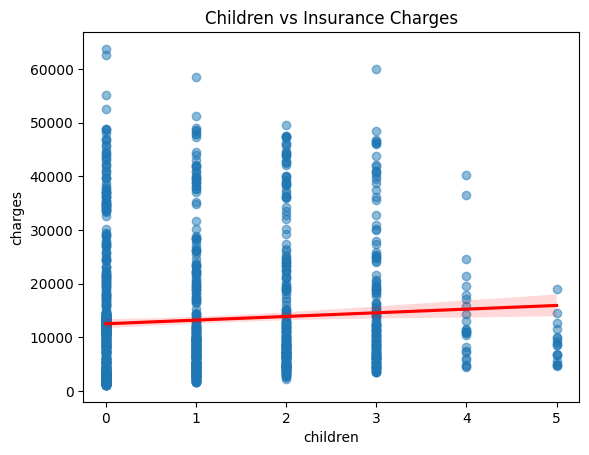

----------------------------------------------------------------------------------------------------


In [16]:
col=['age', 'bmi', 'children']

for i in col:

    sns.regplot(
    x=data[i],
    y="charges",
    data=data,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
    )

    plt.title("Children vs Insurance Charges")
    plt.show()
    print("-"*100)


In [17]:
X = data.drop(columns="charges", axis=1)
y_log = np.log1p(data["charges"])


In [28]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from typing import  List, Tuple
import joblib
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


class InsuranceRegressionModel:

    def __init__(self, X, y_log):

        self.X = X
        self.y_log = y_log


    def data_split(self):

        X_train, X_test, y_train, y_test = train_test_split(
            self.X,
            self.y_log,
            test_size=0.2,
            random_state=42
        )

        return X_train, X_test, y_train, y_test


    def preprocessor(self) -> ColumnTransformer:

        num_features = ["age", "bmi", "children"]
        cat_features = ["sex", "smoker", "region"]

        preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_features),
            ("cat", OneHotEncoder(
                drop="first",
                handle_unknown="ignore"
            ), cat_features)
        ]
        )

        return preprocessor


    def build_model(self, input_dim: int) -> tf.keras.models.Model:

        model = Sequential([
            Dense(
                64,
                activation="relu",
                input_shape=(input_dim,)
            ),
            Dense(
                32,
                activation="relu"
            ),
            Dense(1)
        ])

        return model


    def compaile_and_fit(self, epochs: int) -> tf.keras.models.Model:

        X_train, X_test, y_train, y_test = self.data_split()
        preprocessor = self.preprocessor()


        X_train_processed = preprocessor.fit_transform(X_train)
        input_dim = X_train_processed.shape[1]

        print(f"shape: {input_dim}")


        model = self.build_model(input_dim=input_dim)

        joblib.dump(preprocessor, "preprocessor.pkl")

        model.compile(
            loss="mse",
            optimizer=Adam(learning_rate=0.001),
            metrics=["mae", "r2_score"]
        )

        hist = model.fit(
            X_train_processed,
            y_train,
            validation_data=(
                preprocessor.transform(X_test),
                y_test
            ),
            epochs=epochs
        )

        model.save("model.h5")

        return model, hist

In [30]:
model_obj = InsuranceRegressionModel(X, y_log)

model, hist = model_obj.compaile_and_fit(epochs=70)

shape: 8
Epoch 1/70
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 74.6393 - mae: 8.5835 - r2_score: -92.5233 - val_loss: 48.0572 - val_mae: 6.8489 - val_r2_score: -52.4646
Epoch 2/70
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 38.3035 - mae: 6.0114 - r2_score: -46.8043 - val_loss: 10.6379 - val_mae: 2.8723 - val_r2_score: -10.8348
Epoch 3/70
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.8719 - mae: 2.2054 - r2_score: -7.1824 - val_loss: 3.8922 - val_mae: 1.5505 - val_r2_score: -3.3302
Epoch 4/70
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3285 - mae: 1.4272 - r2_score: -3.0875 - val_loss: 3.2256 - val_mae: 1.4056 - val_r2_score: -2.5886
Epoch 5/70
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7806 - mae: 1.3147 - r2_score: -2.4554 - val_loss: 2.9190 - val_mae: 1.3352 - val_r2_score: -2.2475
Epoch 6/70
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6882 - mae: 1.3059 - r2_score: -2.3691 - val_loss: 2.6281 - val_mae: 1.2581 - val_r2_score: -1.9238
Epoch 7/70
34/34 ━━━

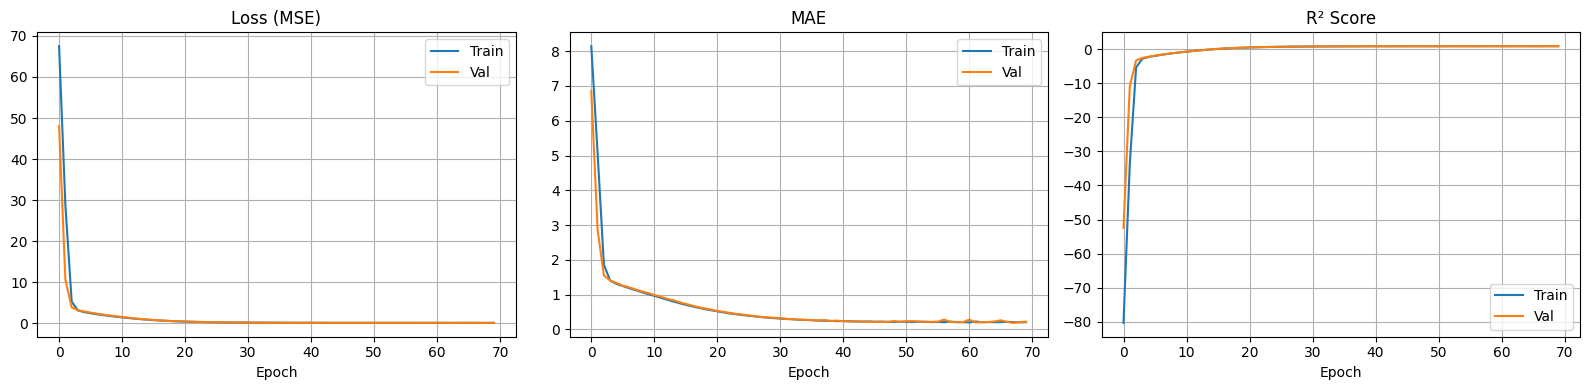

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Loss
axes[0].plot(hist.history["loss"], label="Train")
axes[0].plot(hist.history["val_loss"], label="Val")
axes[0].set_title("Loss (MSE)")
axes[0].set_xlabel("Epoch")
axes[0].legend()
axes[0].grid(True)

# MAE
axes[1].plot(hist.history["mae"], label="Train")
axes[1].plot(hist.history["val_mae"], label="Val")
axes[1].set_title("MAE")
axes[1].set_xlabel("Epoch")
axes[1].legend()
axes[1].grid(True)

# R2
axes[2].plot(hist.history["r2_score"], label="Train")
axes[2].plot(hist.history["val_r2_score"], label="Val")
axes[2].set_title("R² Score")
axes[2].set_xlabel("Epoch")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()


In [34]:
X_train, X_test, y_train, y_test = train_test_split(
            X,
            y_log,
            test_size=0.2,
            random_state=42
        )

In [35]:
preprocessosr = joblib.load("preprocessor.pkl")
X_test_transformed = preprocessosr.transform(X_test)

In [36]:
y_pred_log = model.predict(X_test_transformed).ravel()
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, r2_score

r2 = r2_score(y_true, y_pred)

mae = mean_absolute_error(y_true, y_pred)
rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))

print("MAE:", mae)
print("RMSLE:", rmsle)
print("R² Score:", r2)


MAE: 2511.0891149417557
RMSLE: 0.3697206827532416
R² Score: 0.854603583305266


In [40]:
X.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region'], dtype='object')

In [46]:
age = int(input("Enter the age: "))
sex = input("Enter the sex (male/female): ")
bmi = float(input("Enter the BMI: "))
children = int(input("Enter the number of children: "))
smoker = input("Enter the smoking status (yes/no): ")
region = input("Enter the region (northeast/northwest/southeast/southwest): ")

dicts = {
    "age": [age],
    "bmi": [bmi],
    "children": [children],
    "sex": [sex],
    "smoker": [smoker],
    "region": [region]
}

data_new = pd.DataFrame(dicts)
preprocessosr = joblib.load("preprocessor.pkl")
pred_data_transformed = preprocessosr.transform(data_new)
y_pred_log = model.predict(pred_data_transformed).ravel()
y_pred = np.expm1(y_pred_log)

print(f"predicted Charges is : {y_pred}")

Enter the age: 50
Enter the sex (male/female): male
Enter the BMI: 30.97
Enter the number of children: 3
Enter the smoking status (yes/no): no
Enter the region (northeast/northwest/southeast/southwest): northwest
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
predicted Charges is : [10115.257]
